# ［たんぽぽ］表面付着物の分類

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
import os
os.chdir('/content/drive/MyDrive/Data_HonokaKiryu/')

In [ ]:
import tensorflow as tf
import keras

In [ ]:
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
#from keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
import re
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

import seaborn as sns

#from keras.callbacks import TensorBoard
#from keras.datasets import mnist
#from keras.layers import Input, Dense
#from keras.models import Model

In [ ]:
#画像サイズがが704x480 #88x60
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
batch_size =  "16" #@param[8, 16, 32, 64, 128, 256]
batch_size = int(batch_size)

In [ ]:
epochs = "18" #@param[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
epochs = int(epochs)

## データの読み込み

In [ ]:
# データの保蔵先ディレクトリー
SAVE_DATE_DIR_PATH = "/content/drive/MyDrive/Data_HonokaKiryu/"
train_dir = "/content/drive/MyDrive/Data_HonokaKiryu/TrainingData11"
test_dir = "/content/drive/MyDrive/Data_HonokaKiryu/TestData11"

train_sputter_dir = os.path.join(train_dir, '1Sputter') #学習用のSputterのディレクトリ
train_fiber_dir = os.path.join(train_dir, '2Fiber') #学習用のFiberのディレクトリ
train_block_dir = os.path.join(train_dir, '3Block') #学習用のBlockのディレクトリ
train_bar_dir = os.path.join(train_dir, '4Bar') #学習用のBarのディレクトリ
train_agfragment_dir = os.path.join(train_dir, '5AGFragment') #学習用のAGFragmentのデェレクトリ

test_sputter_dir = os.path.join(test_dir, '1Sputter') #テスト用のSputterのデェレクトリ
test_fiber_dir = os.path.join(test_dir, '2Fiber') #テスト用のFiberのデェレクトリ
test_block_dir = os.path.join(test_dir, '3Block') #テスト用のBlockのデェレクトリ
test_bar_dir = os.path.join(test_dir, '4Bar') #テスト用のBarのデェレクトリ
test_agfragment_dir = os.path.join(test_dir, '5AGFragment') #テスト用のAGFragmentのデェレクトリ

## データの理解

In [ ]:
num_sputter_tr = (len(os.listdir(train_sputter_dir)) - 1) #.DS_Storeを除く
num_fiber_tr = (len(os.listdir(train_fiber_dir)) - 1)
num_block_tr = (len(os.listdir(train_block_dir)) - 1)
num_bar_tr = (len(os.listdir(train_bar_dir)) - 1)
num_agfragment_tr = (len(os.listdir(train_agfragment_dir)) - 1)

num_sputter_ts = (len(os.listdir(test_sputter_dir)) - 1)
num_fiber_ts = (len(os.listdir(test_fiber_dir)) - 1)
num_block_ts = (len(os.listdir(test_block_dir)) - 1)
num_bar_ts = (len(os.listdir(test_bar_dir)) - 1)
num_agfragment_ts = (len(os.listdir(test_agfragment_dir)) - 1)

total_train = num_sputter_tr + num_fiber_tr + num_block_tr + num_bar_tr + num_agfragment_tr
total_test = num_sputter_ts + num_fiber_ts + num_block_ts + num_bar_ts + num_agfragment_ts

In [ ]:
print('total training sputter images:', num_sputter_tr)
print('total training fiber images:', num_fiber_tr)
print('total training block images:', num_block_tr)
print('total training bar images:', num_bar_tr)
print('total training agfragment images:', num_agfragment_tr)

print('total test sputter images:', num_sputter_ts)
print('total test fiber images:', num_fiber_ts)
print('total test block images:', num_block_ts)
print('total test bar images:', num_bar_ts)
print('total test agfragment images:', num_agfragment_ts)
print("--")
print('Total training images:', total_train)
print('Total test images:', total_test)

## データ拡張(Data augmentation)

In [ ]:
#画像データの正規化の設定
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    zca_whitening=True, #ZCA ZCA whitening
                    #validation_split=0.2 #検証用データセット分割
)
#total_val = total_train * 0.2

image_gen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
#ディレクトリを指定
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     subset='training', #train
                                                     )

# # test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
# #                                                    directory=test_dir,
# #                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
# #                                                    class_mode='binary')

## 配列に格納

In [ ]:
import glob

folder = list(train_data_gen.class_indices.keys())
print(folder)
label_class_number = len(folder)

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
#画像ファイルを順番に読み込み、リスト型配列に変換
for index, folder_name in enumerate(folder):
    read_data = train_dir + '/' + folder_name
    bmp_files = glob.glob(read_data + '/*.bmp')

    for i, bmp_file in enumerate(bmp_files):
        img = load_img(bmp_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        train_images.append(img_array)
        train_labels.append(index)
        # train_images[i] = img_array
        # train_labels[i] = index

    for i, bmp_file in enumerate(bmp_files):
        img = load_img(bmp_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        test_images.append(img_array)
        test_labels.append(index)
        # test_images[i] = img_array
        # test_labels[i] = index

#リスト型からNumPy配列に変換
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

#画像データの標準化
train_images = tf.keras.applications.vgg16.preprocess_input(train_images)

## 学習用画像の可視化

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:5])

## モデルの構築と学習

In [86]:
#交差検証
kf = KFold(n_splits=label_class_number, shuffle=True)

i = 0

for train_index, valid_index in kf.split(train_images, train_labels):
    #x:画像, y:ラベル
    X_tra, X_valid = train_images[train_index], train_images[valid_index]
    y_tra, y_valid = train_labels[train_index], train_labels[valid_index]

    #転移学習のベースモデルとしてVGG16のモデルと重みをインポート
    vgg16_model = VGG16(include_top=False, #全結合層を除外
                        weights='imagenet',
                        #input_tensor=train_images,
                        input_shape=train_data_gen.image_shape,
    )
    
    #重みを固定
    vgg16_model.trainable = False

    #全結合層の構築
    x = vgg16_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    #x = Dropout(0.2)(x)
    
    #入力画像の形状
    transfer_learning_inputs = vgg16_model.inputs

    #predictions層の追加
    transfer_learning_prediction = Dense(
                                    units=label_class_number, activation='softmax')(x)

    #VGG16と構築した全結合層を結合
    transfer_learning_model = tf.keras.Model(inputs=transfer_learning_inputs,
                                            outputs=transfer_learning_prediction)

    #モデルのコンパイル
    transfer_learning_model.compile(optimizer='adam',
                                    loss='sparse_categorical_crossentropy', #categorical_crossentropyだとエラー
                                    metrics=['accuracy'])    

    i+=1
    print("-----", i, "----------")
    #モデルの学習
    history = transfer_learning_model.fit(X_tra, y_tra,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_valid, y_valid))
    
# 構築したモデルを確認
transfer_learning_model.summary()

----- 1 ----------
Epoch 1/18
13/13 [==============================] - 4s 234ms/step - loss: 6.2103 - accuracy: 0.4184 - val_loss: 3.4533 - val_accuracy: 0.5306
Epoch 2/18
13/13 [==============================] - 1s 95ms/step - loss: 1.5023 - accuracy: 0.7602 - val_loss: 2.6198 - val_accuracy: 0.6122
Epoch 3/18
13/13 [==============================] - 1s 94ms/step - loss: 0.8208 - accuracy: 0.8316 - val_loss: 3.2377 - val_accuracy: 0.5714
Epoch 4/18
13/13 [==============================] - 1s 94ms/step - loss: 0.5821 - accuracy: 0.8724 - val_loss: 2.2147 - val_accuracy: 0.7551
Epoch 5/18
13/13 [==============================] - 1s 95ms/step - loss: 0.0832 - accuracy: 0.9745 - val_loss: 1.5936 - val_accuracy: 0.7551
Epoch 6/18
13/13 [==============================] - 1s 94ms/step - loss: 0.0793 - accuracy: 0.9694 - val_loss: 1.9067 - val_accuracy: 0.7347
Epoch 7/18
13/13 [==============================] - 1s 94ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 1.6708 - val_accuracy: 

## 損失関数、正解率

In [87]:
#テストデータの画像分類結果を標準出力
print("テストデータの画像分類結果")
test_loss, test_acc = transfer_learning_model.evaluate(test_images, test_labels,
                                     batch_size=batch_size,
                                     verbose=1)
print("[損失関数, 正解率]")
print("[", test_loss, test_acc, "]")

テストデータの画像分類結果
16/16 [==============================] - 1s 77ms/step - loss: 0.3863 - accuracy: 0.8939
[損失関数, 正解率]
[ 0.3862561285495758 0.8938775658607483 ]


## グラフ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


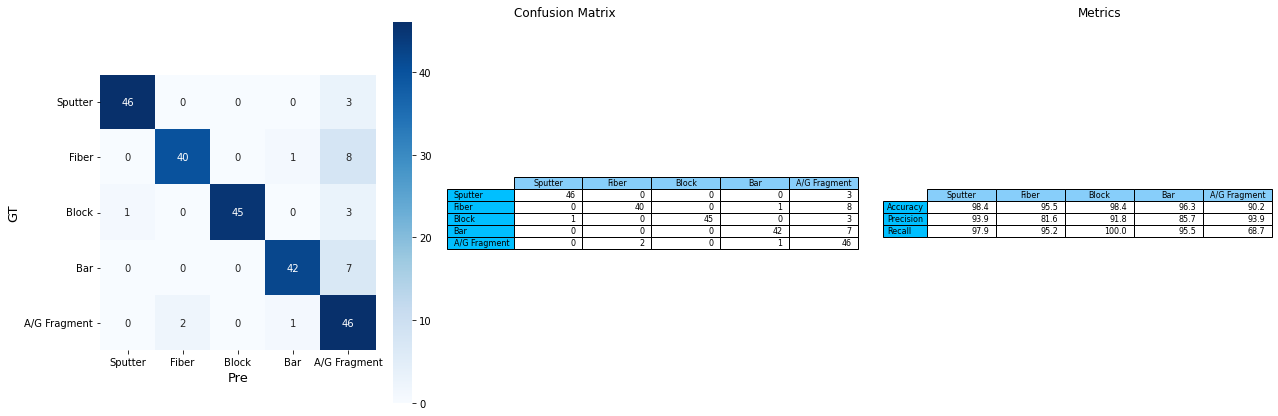

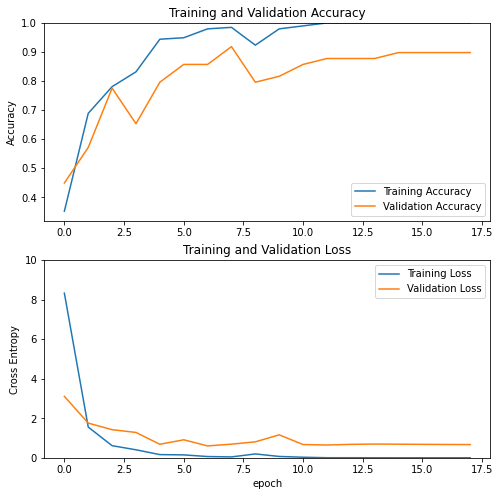

In [89]:
#正解率
def class_accuracy(label, conf_mat):
    return (conf_mat[label][label] + (np.sum(conf_mat) - (np.sum(conf_mat[:, label])+np.sum(conf_mat[label])-conf_mat[label][label]))) / np.sum(conf_mat)
    
#精度(適合率)
def class_precision(label, conf_mat):
    return conf_mat[label][label] / np.sum(conf_mat[label])

#再現率
def class_recall(label, conf_mat):
    return conf_mat[label][label] / np.sum(conf_mat[:, label])

#予測
predictions = transfer_learning_model.predict(test_images)
pred = predictions.argmax(axis=1)

#混同行列
conf_mat = confusion_matrix(test_labels, pred)
#print(conf_mat)
labels = ["Sputter", "Fiber", "Block", "Bar", "A/G Fragment"]

Accuracy = []
Precision = []
Recall = []
for i in range(label_class_number):
    Accuracy = np.append(Accuracy, class_accuracy(i, conf_mat))
    Precision = np.append(Precision, class_precision(i, conf_mat))
    Recall = np.append(Recall, class_recall(i, conf_mat))

table_values = []
table_values = np.append(table_values, Accuracy)
table_values = np.append(table_values, Precision)
table_values = np.append(table_values, Recall)
table_values = np.round(table_values * 100, 1)
table_values = table_values.reshape(3, -1)
#print(table_values)

#表
nrow = 1
ncol = 3
plt.figure(figsize=(7*ncol, 7*nrow))

#表1
plt.subplot(nrow, ncol, 1)
conf_mat = confusion_matrix(test_labels, pred)
cm = conf_mat
cm = pd.DataFrame(data=cm, index=labels, columns=labels)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Pre", fontsize=13, rotation=0)
plt.ylabel("GT", fontsize=13)
ax = plt.gca()
ax.set_ylim(len(cm), 0)

#表2
plt.subplot(nrow, ncol, 2)
df = pd.DataFrame(conf_mat, columns=labels)

plt.title('Confusion Matrix', loc='left')
plt.axis('off')
plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.columns, rowColours=["deepskyblue"]*5, colColours=["lightskyblue"]*5,loc="center")

#表3
plt.subplot(nrow, ncol, 3)
labels_metrics = ["Accuracy", "Precision", "Recall"]
df3 = pd.DataFrame(table_values, columns=labels, index=labels_metrics)
df3.colums=labels_metrics

plt.title('Metrics', loc='center')
plt.axis('off')
plt.table(cellText=df3.values, colLabels=df3.columns, rowLabels=df3.index, rowColours=["deepskyblue"]*3, colColours=["lightskyblue"]*5, loc="center")


plt.show()
print()

#訓練と検証
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#正解率
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#損失関数
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()